In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import torch
import torchvision
import cv2
from PIL import Image
import os

In [0]:
import pandas as pd

In [0]:
from torchvision import datasets, transforms

In [0]:
import zipfile

In [0]:
with zipfile.ZipFile('/content/drive/My Drive/custom_dataset.zip','r') as zip_ref:
  zip_ref.extractall('/content/Mask Detection')

In [0]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [0]:
transform = transforms.Compose([
                  transforms.RandomResizedCrop(size=256),
                  transforms.RandomRotation(degrees=15),
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor(),
                  transforms.Normalize(mean, std)
])

In [0]:
from torch.utils.data import DataLoader,Dataset

In [0]:
class CustomDataset(Dataset):

  def __init__(self,csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    y_label = torch.tensor(int(self.annotations.iloc[index,-1]))
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index,1])
    image = Image.open(img_path)
    

    if self.transform:
      image = self.transform(image)

    return (image, y_label)


In [0]:
dataset = CustomDataset('/content/Mask Detection/my_file/csv_file.csv', '/content/Mask Detection/my_file/Combined', transform=transform)

In [0]:
train_size = int(0.8 * 1376)
test_size = 1376 - train_size

In [0]:
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [0]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)

In [0]:
images, labels = iter(trainloader).next()
print(images.shape)
print(labels.shape)
print(labels)

torch.Size([16, 3, 256, 256])
torch.Size([16])
tensor([0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1])


In [0]:
testloader = DataLoader(testset, batch_size=16, shuffle=True)

In [0]:
from torch import optim
import torch.nn as nn

In [0]:
from torchvision import models

In [0]:
def create_model(n_classes):
  model = models.resnet18(pretrained=True)

  n_features = model.fc.in_features

  model.fc = nn.Sequential(
      nn.Linear(n_features, n_classes),
      nn.Softmax(dim=1)
  )

  return model

In [0]:
base_model = create_model(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


#Evaluation

In [0]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device)
        outputs = base_model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
opt = optim.SGD(base_model.parameters(),lr=0.001,momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

#Training

Epoch: 0/4, Test acc: 89.49, Train acc: 91.27
Epoch: 1/4, Test acc: 92.75, Train acc: 92.91
Epoch: 2/4, Test acc: 92.75, Train acc: 94.18
Epoch: 3/4, Test acc: 95.29, Train acc: 93.64


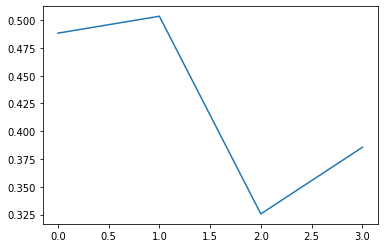

CPU times: user 30min, sys: 12 s, total: 30min 12s
Wall time: 30min 14s


In [0]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 4
     
for epoch in range(max_epochs):
     
  for i, data in enumerate(trainloader, 0):
     
    inputs, labels = data
    #inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()
     
    outputs = base_model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()  
         
    loss_arr.append(loss.item())
        
  loss_epoch_arr.append(loss.item())
         
  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

#Saving and Loading

In [0]:
torch.save(base_model.state_dict(), '/content/model.pth')

In [0]:
model = base_model(2)
model.load_state_dict(torch.load('/content/sample_data/Mask Detection/Model.pth'))
model.eval()

#Test Section

In [0]:
img.shape

torch.Size([3, 256, 256])

In [0]:
npim = np.transpose(img,(1,2,0))

In [0]:
plt.imshow(np.squeeze(npim))
plt.show()

In [0]:
img = img.unsqueeze(0)

In [0]:
pred_ = base_model(img)

In [0]:
pred

tensor([[0.5619, 0.4381]], grad_fn=<SoftmaxBackward>)

In [0]:
imag = cv2.imread('/content/Mask Detection/my_file/Combined/102.jpg')

In [0]:
cv2.imshow('name', imag)

DisabledFunctionError: ignored

In [0]:
imag = cv2.resize(imag, (256,256))

In [0]:
imag_ = imag[:,:,::-1].transpose((2,0,1)).copy()

In [0]:
#imag_ = imag_[np.newaxis, :,:,:]/255.0

In [0]:
imag_ = imag_/255.0

In [0]:
imag_ = torch.from_numpy(imag_).float().div(255.0).unsqueeze(0)

In [0]:
pred = base_model(imag_)

In [0]:
pred

tensor([[0.5619, 0.4381]], grad_fn=<SoftmaxBackward>)

In [0]:
images, labels = iter(testloader).next()
print(labels.shape)
print(images.shape)
print(labels)

torch.Size([16])
torch.Size([16, 3, 256, 256])
tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0])


In [0]:
images[2].shape

torch.Size([3, 256, 256])

In [0]:
predictions = base_model(images[0])

RuntimeError: ignored

In [0]:
preds = torch.argmax(predictions,dim=1)

In [0]:
preds

tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
       grad_fn=<NotImplemented>)

In [0]:
with zipfile.ZipFile('/content/imfold/imfolder/imfolder2.zip','r') as zip_ref:
  zip_ref.extractall('/content/imfold2')

In [0]:
sampleset = torchvision.datasets.ImageFolder('/content/imfold2',transform=transform)

In [0]:
sampleloader = DataLoader(sampleset,batch_size=4,shuffle=False)

In [0]:
images, labels = iter(sampleloader).next()
print(images.shape)
print(labels)

torch.Size([4, 3, 256, 256])
tensor([0, 0, 0, 0])


In [0]:
re = images[1].unsqueeze(0)

In [0]:
re.shape

torch.Size([1, 3, 256, 256])

In [0]:
preds = base_model(re)

In [0]:
pred = torch.argmax(preds, dim=1)

In [0]:
pred.item()

0

In [0]:
nwim = images[2].unsqueeze(0)

In [0]:
nwim.shape

NameError: ignored

#Video Processing

In [0]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [0]:
cam = cv2.VideoCapture(0)

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [0]:
while(True):

    ret,img=cam.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=img[y:y+w,x:x+w]
        face_trans = transform(face_img)
        face_trans = np.transpose(face_trans, (2,0,1))
        #resized=cv2.resize(face_img,(100,100))
        #normalized=resized/255.0
        #reshaped=np.reshape(normalized,(1,100,100,1))
        face = face_trans.unsqueeze(0)
        result = base_model(face)

        y=torch.argmax(result,axis=1)
        label = y.item()
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

error: ignored